<center><b><h1>Relocation Search Optimiser</h1></B></center>

<center>
<img src="twohouses.png" alt="Kitten" title="A cute kitten" width="300" height="285" /> 
</center>

<h2><b>Contents</b></h2>


* Project description
* Data collection
* Data cleaning and processing
* Linear optimisation

<h3><b>Project Description</b></h3>

If you have ever had to relocate to start a job in a new city, then you know it can be difficult to optimise for every variable when deciding where to live. For example, how would you decide which is the better option of the following two houses?

* House A costs £600 per month and is 30 miles from your workplace
* House B costs £800 per month and is 15 miles from your workplace


<center>
<img src="housesnotable.png" alt="Kitten" title="A cute kitten" width="1000" height="200"> 
</center>

<b>Assumptions</b>

* The value of the commuters time is equivalent to their hourly rate in work, using a reasonable assuption of £11.50 per hour. 
* The commuter arrives at work by 8:45am and departs from work at 5pm, and Google Maps is used to determine the commute time
* The commuter travels to the office 20 times per month.


<center>
<img src="tablenohouse.png" alt="Kitten" title="A cute kitten" width="650" height="150"> 
</center>

Based on this analysis, it works out more beneficial to live further from work, however there is only a small difference between the final total values of £972.50 and £945. The commuter may want to consider if they would pay that difference to enjoy a few precious minutes of sleep every morning. When comparing two houses, this approach doesn't take too long. But in reality, just one rightmove search gives hundreds of results, and it would be impossible to run this analysis manually for every potential rental. It can, therefore, be hard to decide if the savings of living in a 'feeder town' are justified given the extra commute time when compared to living in the city. 

This project aims to streamline this search by automating the collection of rental property location and price data by scraping from rightmove.co.uk and automating the collection of commute time data using Google's Directions Matrix API and Google's Geocoding API. I will then use linear optimisation techniques to narrow down the search to a refined list of properties which can then reasonably be evaluated manually, and provide some simple data visualisations.

<h3><b>Data collection</b></h3>

<b>Importing required libraries<B>

In [599]:
import time
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import regex as re
import pandas as pd
import math
import json

#This is my hidden file holding my Google API key - To use this code yourself, create a variable "apikey" and assign your API key to it as a string
from secret import apikey

payload = {}
headers = {}

<b>Scraping data from Rightmove  :: Selenium<B>

Selenium is used to open the browser and allow the user to search with their selected filters on rightmove.co.uk. This search is then scraped for the individual property links using selenium to loop through the pages, then the information is extracted from individual pages using BeautifulSoup. 

In [565]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.rightmove.co.uk/property-to-rent.html")

In [ ]:
#Find the number of pages at the bottom of the page
numpages=int(driver.find_element("xpath", "/html/body/div[3]/div[2]/div[1]/div[3]/div/div/div/div[2]/span[3]").text)

links=[]

#While there may be eg 10 pages available, it will only be necessary to click 9 times
for g in range(numpages-1):
    #For each page, collect the url of the house links.
    for i in range(0,29,1):
        try:
            x=driver.find_element("xpath", f"/html/body/div[3]/div[2]/div[1]/div[2]/div[5]/div[1]/div/div[{i}]/div/div/div[4]/div[1]/div[2]/a")
            link=x.get_attribute('href')
            links.append(link)
        except:
            # Some adverts are scraped as their xpath is equivalent, but they do not contain a link
            # If the data collected is not a link, this i value is skipped by use of try and except
            continue
    
    #This clicks the "Next" button on the page. A 2 second wait is used to ensure all content is loaded before attempting to scrape
    driver.find_element("xpath", "/html/body/div[3]/div[2]/div[1]/div[3]/div/div/div/div[3]/button").click()
    time.sleep(2)

<b>Scraping data from Rightmove  :: BeautifulSoup<B>

Once all the individual links are collected, BeautifulSoup is used to collect the rent price and location data. The longitude and latitude cannot be found without visiting the link, and visiting all the links using Selenium would be slow as there can be a max of 1050 results per search, so BeautifulSoup is used.

In [ ]:
#Function defined to return the html "soup" which can later be parsed

def extract(url):
    headers = {
        'user agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.34 Safari/537.36'    
    }
    r=requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    listingbroken=False 
    return soup

In [ ]:
#Function defined to clean only the necessary data from the extracted soup

def transform(soup):
    try:
        rent=soup.find('div', class_='_1gfnqJ3Vtd1z40MlC0MzXu')
        rent=rent.find('span').text
        expression=r'[^0-9]'
        rent=re.sub(expression,"", rent)
    except:
        rent="Scrape error"

    try:
        expression=r'[^0-9.-]'

        Location=  soup.find_all('script')
        Loc = str(Location)
        Lat=Loc.find('latitude')
        Latitude=Loc[Lat+8:Lat+20]


        Long=Loc.find('longitude')
        Longitude=Loc[Long+11:Long+20]

      
        Latitude=re.sub(expression,"", Latitude)
        Longitude=re.sub(expression,"", Longitude)
    except:
        Latitude="Scrape error"
        Longitude="Scrape error"
    
    return rent, Longitude, Latitude


<b>Finding workplace longitude and latitude :: Google Geocoding API<B>

The user is asked to enter their work's postcode, and then the latitude and longitude of the workplace is found from Google's Geocoding API. API requests are made using a URL endpoint, and then results are returned as a JSON. 

In [ ]:
while True:
    try:
        postcode=input("What is your workplace postcode?")
        endpoint = f"https://maps.googleapis.com/maps/api/geocode/json?address={postcode}&key={apikey}"
        r = requests.get(endpoint)
        results = r.json()['results'][0]
        worklat = results['geometry']['location']['lat']
        worklong = results['geometry']['location']['lng']
        break
    except:
        print("No location found. Please input a valid postcode or try a nearby postcode")

<b>Finding commute time :: Google Distance Matrix API<B>

The commute time can be computed using Google's Distance matrix API. The user inputs the travel mode, origin, destination and arrival/departure time by editing the base URL endpoint. The arrival/departure time must be entered using EPOCH time, and so I've set this for 8:45am and 5pm on the soonest upcoming Monday. The "for" loop then queries the travel time for both the incoming and outgoing journeys and sums them together.

In [ ]:
def commutetime(latitude,longitude):
    epochs=[['1667810700','arrival'],['1667840400','departure']]
    commutetime=0
    for leg in epochs:
        try:
            url = "https://maps.googleapis.com/maps/api/distancematrix/json?origins={}%2C{}&destinations={}%2C{}&mode=transit&{}_time={}&key={}".format(worklat,worklong,latitude,longitude,leg[1],leg[0],apikey)
            response = requests.request("GET", url, headers=headers, data=payload)
            commutetime+=response.json()['rows'][0]['elements'][0]['duration']['value']
        except:
            commutetime='N/A'
            break
    return commutetime//60 if commutetime != 'N/A' else commutetime

<b>Final data collection and storage in a DataFrame<B>

Previously defined functions are combined to loop through all the links extracted earlier, and for each property the price and location are scraped, and then the total commute time is extracted from Google's Distance Matrix API. This data is collected into a dictionary which is appended to a list, which is then later appended to a Pandas DataFrame.

In [ ]:
rentals=[]
for url in links:
    c=extract(url)
    rent, Longitude, Latitude = transform(c)
    commute=commutetime(Latitude,Longitude)
    dict={
        "Rent (£PCM)":rent,
        "Longitude":Longitude,
        "Latitude":Latitude,
        "URL":url,
        "Commute time (mins)":commute
    }
    rentals.append(dict)
    print(f'Scraped {links.index(url)+1} of {len(links)} links :: {round((links.index(url)*100)/len(links),1)}% complete')

In [ ]:
df=pd.DataFrame(rentals)

In [508]:
df.head(25)
df.dtypes

Rent (£PCM)             int64
Longitude              object
Latitude               object
URL                    object
Commute time (mins)    object
dtype: object

<h3><b>Data cleaning and processing</b></h3>

All results which failed to return a commute time must be excluded from this analysis, then the commute time can be converted into integers.

In [534]:
df=df[df['Commute time (mins)']!='N/A']
df['Commute time (mins)']=df['Commute time (mins)'].apply(pd.to_numeric)

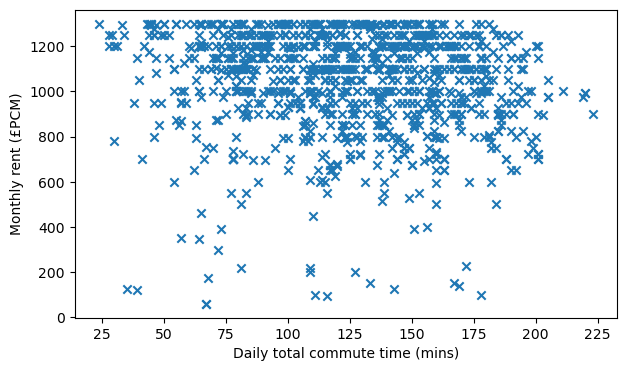

In [587]:
plt.figure(figsize=(7, 4))
plt.scatter(df['Commute time (mins)'],df['Rent (£PCM)'], marker='x')
plt.xlabel('Daily total commute time (mins)')
plt.ylabel('Monthly rent (£PCM)')
plt.show()

<h3><b>Linear programming and optimisation</b></h3>

In order to filter the results, a line can be drawn which indicates the amount of time value spent for the incremental increase in commute time. The slope of this line will be defined by the total monthly commute time multiplied by the hourly rate of £11.50 defined previously. The y intercept is assumed at around £1500, as the max price set during the inital search was £1300 and the £200 buffer allows for the time value of the minimal commute for the closest properties.

Text(0, 0.5, 'Monthly rent (£PCM)')

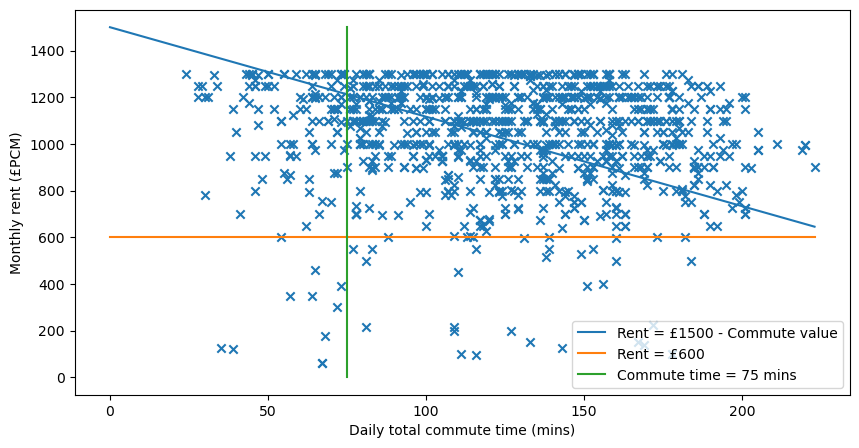

In [584]:
maxprice=1500
hourlyrate=11.50
minprice=600
maxprice=1500
minexpcommute=50
maxcommute=75
hourlyrate=11.50


plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.scatter(df['Commute time (mins)'],df['Rent (£PCM)'] ,marker='x')

x=np.linspace(0,df['Commute time (mins)'].max())
y1=maxprice-hourlyrate*(x/60)*20



x=np.linspace(0,df['Commute time (mins)'].max())
y1=maxprice-hourlyrate*(x/60)*20
y2=np.linspace(minprice,minprice)
y3=np.linspace(0,1500,2)

plt.plot(x,y1, label='Rent = £1500 - Commute value')
plt.plot(x,y2,label='Rent = £600')
plt.plot([maxcommute,maxcommute],y3, label='Commute time = 75 mins')

plt.legend()
plt.xlabel('Daily total commute time (mins)')
plt.ylabel('Monthly rent (£PCM)')

I realised after making the scatter plot that I did not set a minimum price during my initial search, but it can realistically be assumed that any location being rented for less than £600 in London is likely to be a parking space (or a room with less space than a parking space!). Given the large number of results within the remaining range, it is reasonable to filter further to exclude results with a total daily commute of longer than 75 minutes.

In [585]:
def filter(minprice, maxprice, minexpcommute,maxcommute,hourlyrate):
    plt.figure(figsize=(10, 7))
    ax = plt.axes()
    ax.scatter(df['Commute time (mins)'],df['Rent (£PCM)'],marker='x')
    ax.set_ylim([0, 1400])
    ax.set_xlim([0, df['Commute time (mins)'].max()])

    x=np.linspace(0,df['Commute time (mins)'].max())
    y1=maxprice-hourlyrate*(x/60)*20
    y2=np.linspace(minprice,minprice)
    y3=np.linspace(0,1500,2)

    plt.plot(x,y1, color='red', label='line1')
    plt.plot(x,y2, color='red')
    plt.plot([maxcommute,maxcommute],y3, color='red')

    plt.fill_between(x,y1,y2=1500,alpha=0.3)
    plt.fill_between(x,y2,y2=0,alpha=0.3)
    plt.fill_between([maxcommute,df['Commute time (mins)'].max()],0,y2=1500,alpha=0.3)

    plt.xlabel('Daily total commute time (mins)')
    plt.ylabel('Monthly rent (£PCM)')

    dffiltered=df[(df['Rent (£PCM)']>=minprice) & (df['Commute time (mins)']<=maxcommute) & (df['Rent (£PCM)']<=maxprice-hourlyrate*(df['Commute time (mins)']/60)*20)]
    print(f'There are {dffiltered.shape[0]} results')
    return dffiltered

There are 96 results


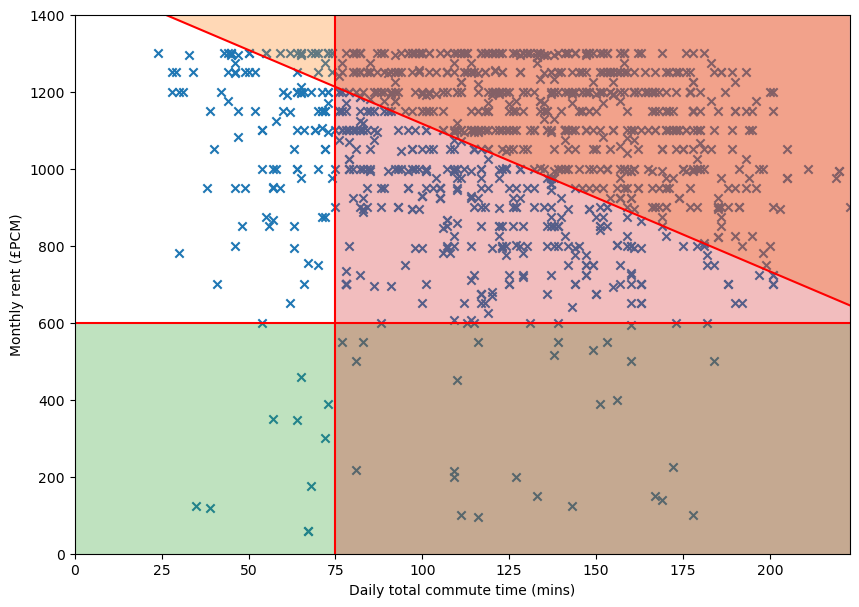

In [586]:
minprice=600
maxprice=1500
minexpcommute=50
maxcommute=75
hourlyrate=11.50

x=filter(minprice, maxprice, minexpcommute,maxcommute,hourlyrate)


The unshaded area of the plot represents the properties which are not filtered. Using the inital assumptions there are 96 results, therefore I can choose to modify the variables as I see fit to filter further. The choice of whether to increase the hourly rate, or to decrease the maxprice variable is dependant on the priorities of the user. If saving the most money is more important, reducing the maxprice variable will select for the properties with the least overall cost, whereas increasing the hourly rate will select towards the more expensive properties with shorter commute times.

Decreasing the maxprice variable will select for cheaper rentals with longer commute times

There are 23 results


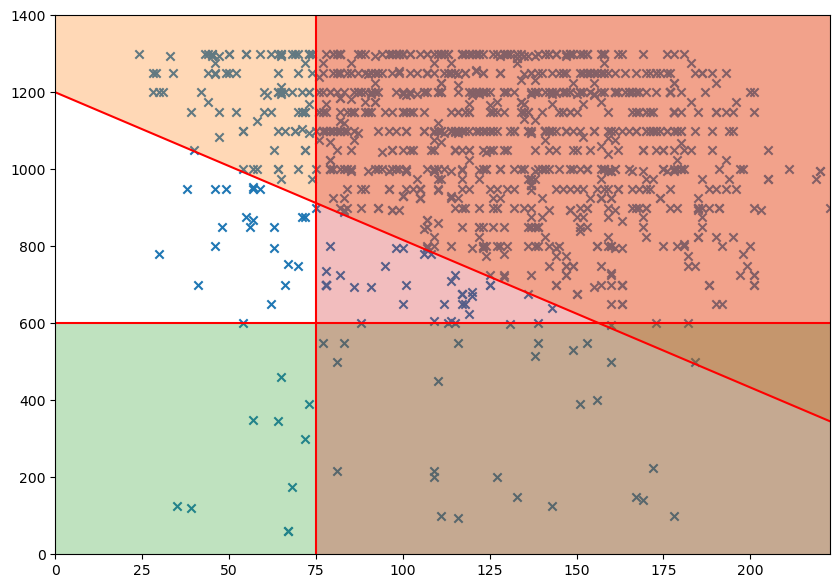

In [551]:
minprice=600
maxprice=1200
minexpcommute=50
maxcommute=75
hourlyrate=11.50

dfmaxprice=filter(minprice, maxprice, minexpcommute,maxcommute,hourlyrate)


Increasing the hourly rate will select for shorter commute times

There are 20 results


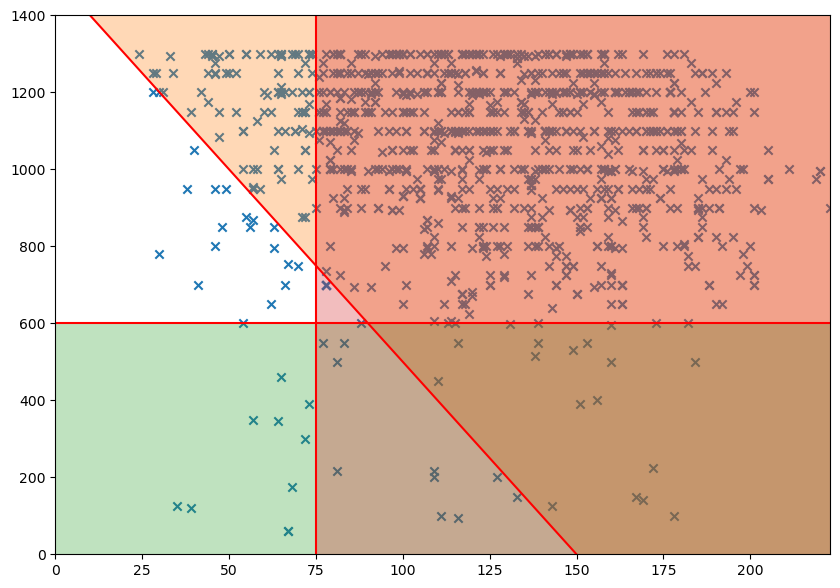

In [552]:
minprice=600
maxprice=1500
minexpcommute=50
maxcommute=75
hourlyrate=30

dfhourlyrate=filter(minprice, maxprice, minexpcommute,maxcommute,hourlyrate)


In [556]:
meanrenthourly=int(dfhourlyrate.describe().loc['mean']['Rent (£PCM)'])
meantravelhourly=int(dfhourlyrate.describe().loc['mean']['Commute time (mins)'])
meanrentmax=int(dfmaxprice.describe().loc['mean']['Rent (£PCM)'])
meantravelmax=int(dfmaxprice.describe().loc['mean']['Commute time (mins)'])

print(f"Reducing the maxprice variable to £1200:        mean rent: £{meanrentmax}     mean travel time: {meantravelmax} minutes    {dfmaxprice.shape[0]} results")  
print(f"Increasing the hourly rate to £30 per hour:     mean rent: £{meanrenthourly}     mean travel time: {meantravelhourly} minutes    {dfhourlyrate.shape[0]} results")

Reducing the maxprice variable to £1200:        mean rent: £833     mean travel time: 56 minutes    23 results
Increasing the hourly rate to £30 per hour:     mean rent: £856     mean travel time: 50 minutes    20 results


Another way the potential rental properties could be compared is by adding together the commute value and the rental price to find a 'total cost of living' for each property. The 20 best properties according to total cost of living are then opened automatically in the browser to allow the user to quickly browse the selected options.

In [562]:
hourlyrate=11.50
dffiltered['Total cost (£PCM)']=(dffiltered['Commute time (mins)']/60)*20*hourlyrate+dffiltered['Rent (£PCM)']
dffiltered=dffiltered.sort_values(['Total cost (£PCM)'], ascending=True)

dffiltered.head()

,Rent (£PCM),Longitude,Latitude,URL,Commute time (mins),Total cost (£PCM)
65,600,-0.301805,51.4031,https://www.rightmove.co.uk/properties/1256575...,54,807.0
230,700,-0.234717,51.41343,https://www.rightmove.co.uk/properties/1286245...,41,857.166667
20,650,-0.114492,51.36982,https://www.rightmove.co.uk/properties/1286744...,62,887.666667
480,780,-0.160089,51.4171,https://www.rightmove.co.uk/properties/1285623...,30,895.0
6,700,-0.12338,51.41102,https://www.rightmove.co.uk/properties/1146851...,66,953.0


In [566]:
for i in dffiltered['URL'].values[0:10]:
    driver.switch_to.new_window('tab')
    driver.get(i)